In [36]:
import hashlib

import matplotlib.pyplot as plt
import numpy as np

from icp_algo import icp

# Задаем типы для удобства
RoomType = np.ndarray
ObstaclesType = list[list[int]]
PointType = tuple[float, float]
ScanType = list[tuple[int, float]]


In [43]:
def laser_scan_with_distances(
    robot_position: PointType,
    room: RoomType,
    angle0: int = 0,
    angle_step: int = 2,
    max_distance: int | None = None,
) -> ScanType:
    """Имитация лидара.

    Возвращает массив из пар (угол в градусах, расстояние)
    """
    map_size = len(room)
    if max_distance is None:
        max_distance = int(map_size * 1.415)

    scan = []
    for angle in np.arange(0, 360, angle_step):
        theta = np.radians(angle0 + angle)
        distance = -1  # Default to max_distance if no obstacle is detected
        for r in range(1, max_distance):
            x = int(robot_position[0] + r * np.cos(theta))
            y = int(robot_position[1] + r * np.sin(theta))

            # Check for boundaries and obstacles
            if x < 0 or y < 0 or x >= map_size or y >= map_size or room[y, x] == 1:
                distance = r - 1
                break

        scan.append((angle, distance))
    return scan


def get_uniq_scan_name(
    robot_position: PointType,
    column_positions: ObstaclesType,
    angle0: int,
    angle_step: int,
    max_distance: float,
) -> str:
    """Генерируем уникальное имя для скана на основе данных среды."""
    map_config = hashlib.sha224(str(column_positions).encode("utf8")).hexdigest()[:4]
    pose = f"{robot_position[0]};{robot_position[1]}"
    return f"scan__pose-{pose}__angle-{angle0}__step-{angle_step}__maxd-{max_distance}__map-{map_config}"


def draw_room(
    robot_position: PointType,
    room: RoomType,
    column_positions: ObstaclesType,
    scan: ScanType,
    angle0: int,
    scan_name: str,
) -> None:
    """Визуализируем скан."""
    plt.figure(figsize=(8, 8))
    plt.imshow(room, cmap="Greys", origin="lower")
    plt.scatter(*zip(*column_positions), marker="s", color="red", label="Columns")

    for angle, distance in scan:
        if distance != -1:  # Check if an obstacle was detected
            color = "green"
            line_width = 0.3
            if angle == 0:
                line_width = 1
                color = "orange"
            rad = np.radians(angle0 + angle)
            end_point = (robot_position[0] + distance * np.cos(rad), robot_position[1] + distance * np.sin(rad))
            plt.plot([robot_position[0], end_point[0]], [robot_position[1], end_point[1]], color=color, linewidth=line_width)

    plt.scatter(robot_position[0], robot_position[1], color="blue", label="Robot", s=100)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"Room with Robot and Laser Scan {scan_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def to_polar(point: PointType) -> PointType:
    """Перевод из прямоугольной системы координат в полярную.
    Угол возвращается в градусах.
    """
    return float(np.degrees(np.arctan2(point[1], point[0]))), np.linalg.norm(point)


def to_cartesian(point: PointType) -> PointType:
    """Перевод из полярной системы координат в прямоугольную.
    Угол принимается в градусах.
    """
    angle, r = point
    theta = np.radians(angle)
    return r * np.cos(theta), r * np.sin(theta)


def transform_polar_scan_to_points_array(scan: ScanType) -> np.ndarray:
    """Преобразуем скан в массив точек на плоскости в прямоугольной системе координат."""
    return np.array([to_cartesian(point) for point in scan])


def transform_point(point: PointType, transform_matrix: np.ndarray) -> PointType:
    """Применяем трансформацию к точке."""
    x, y = point
    transformed_point = np.dot(transform_matrix, np.array([x, y, 1]))
    return transformed_point[:2]


def transform_points_array(points: list[PointType], transform_matrix: np.ndarray) -> list[PointType]:
    """Применяем трансформацию к массиву точек."""
    return [transform_point(point, transform_matrix) for point in points]


def get_circle_error_percent(
    real_pose: PointType,
    transformed_pose: PointType,
    map_size: int,
) -> float:
    """Считаем ошибку как площадь круга с радиусом расстояния ошибки деленную на площадь комнаты."""
    r = np.linalg.norm(np.subtract(real_pose, transformed_pose))
    return 100 * np.pi * (r ** 2) / (map_size ** 2)


def run_scan_matching(
    position_a,
    angle0_a,
    position_b,
    angle0_b,
    map_size: int,
    room: RoomType,
    column_positions: ObstaclesType,
    angle_step: int,
    max_distance: int | None,
    draw_vector_length: int,
) -> None:
    scan_a = laser_scan_with_distances(
        robot_position=position_a,
        room=room,
        angle0=angle0_a,
        angle_step=angle_step,
        max_distance=max_distance,
    )

    scan_a_name = get_uniq_scan_name(
        robot_position=position_a,
        column_positions=column_positions,
        angle0=angle0_a,
        angle_step=angle_step,
        max_distance=max_distance,
    )

    draw_room(
        robot_position=position_a,
        room=room,
        column_positions=column_positions,
        scan=scan_a,
        angle0=angle0_a,
        scan_name=scan_a_name,
    )

    scan_b = laser_scan_with_distances(
        robot_position=position_b,
        room=room,
        angle0=angle0_b,
        angle_step=angle_step,
        max_distance=max_distance,
    )

    scan_b_name = get_uniq_scan_name(
        robot_position=position_b,
        column_positions=column_positions,
        angle0=angle0_b,
        angle_step=angle_step,
        max_distance=max_distance,
    )

    draw_room(
        robot_position=position_b,
        room=room,
        column_positions=column_positions,
        scan=scan_b,
        angle0=angle0_b,
        scan_name=scan_b_name,
    )

    # Запускаем скан матчинг
    angle_coef = 1 if angle0_b > angle0_a else -1

    expected_rotate_angle = angle0_b - angle0_a
    expected_delta = np.subtract(position_b, position_a)

    scan_a = transform_polar_scan_to_points_array(scan_a)
    scan_b = transform_polar_scan_to_points_array(scan_b)

    final_transform_matrix, error = icp(scan_a.T, scan_b.T, max_time=2)
    T = final_transform_matrix

    dx = T[0, 2]
    dy = T[1, 2]
    rotation = angle_coef * np.degrees(np.arccos(final_transform_matrix[0][0]))
    rotate_angle = rotation

    scan_a_transformed = transform_points_array(scan_a, final_transform_matrix)

    plt.figure(1)
    plt.scatter(*zip(*scan_a), label="scan_a")
    plt.scatter(*zip(*scan_b), label="scan_b")
    plt.scatter(*zip(*scan_a_transformed), label="scan_a_transformed", s=7)
    plt.axis("equal")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    plt.figure(3)

    print("Оценка окончательной матрицы трансформации:")
    print(final_transform_matrix)

    scan_a_pose_t = [position_a[0] + dx, position_a[1] + dy]

    print("Начальная позиция (scan1):")
    print(position_a)

    print("Ожидаемая трансформированная позиция (scan2):")
    print(position_b)

    print("Трансформация (dx, dy):")
    print([dx, dy])

    print("Ожидаемая трансформация (dx, dy):")
    print(expected_delta)

    print("Трансформация (angle, r):")
    print(to_polar((dx, dy)))

    print("Трансформированная начальная позиция (scan_a_pose_t):")
    print(scan_a_pose_t)

    print("Разница:")
    diff = np.subtract(position_b, scan_a_pose_t)
    print(diff)
    print("Разница (r):")
    diff_distance = np.linalg.norm(diff)
    print(diff_distance)

    print("% Ошибки как площадь круга / на площадь карты:")
    print(round(get_circle_error_percent(position_b, scan_a_pose_t, map_size), 2))

    print(f"Погрешность в % (размер карты {map_size}):")
    print(round(100 * (diff_distance / map_size), 2))

    print("Удаленность реальных позиций:")
    print(np.linalg.norm(np.subtract(scan_a_pose_t, position_a)))

    print("Угол поворота:")
    print(rotate_angle)

    print("Ожидаемый угол поворота:")
    print(expected_rotate_angle)

    print("Разница угла поворота:")
    print(rotate_angle - expected_rotate_angle)

    print("Разница угла поворота, %:")
    print(round(100 * (rotate_angle - expected_rotate_angle) / expected_rotate_angle, 2))

    print("% ошибки от 360 градусов:")
    print(round(100 * (rotate_angle - expected_rotate_angle) / 360, 2))

    plt.plot(*position_a, "o", label="scan1_pose")
    plt.plot(*scan_a_pose_t, "o", label="scan1_pose_t")
    plt.plot(*position_b, "o", label="scan2_pose")
    plt.plot([scan_a_pose_t[0], position_b[0]], [scan_a_pose_t[1], position_b[1]], "-.", label="diff")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(34)
    pose1_vx, pose1_vy = to_cartesian((angle0_a, draw_vector_length))
    plt.quiver(*position_a, pose1_vx, pose1_vy, angles='xy', scale_units="xy", scale=1, label="scan1", color="r")

    pose2_vx, pose2_vy = to_cartesian((angle0_b, draw_vector_length))
    plt.quiver(*position_b, pose2_vx, pose2_vy, angles='xy', scale_units="xy", scale=1, label="scan2", color="g")

    pose1_t_vx, pose1_t_vy = to_cartesian((ANGLE0_A + rotate_angle, draw_vector_length))
    plt.quiver(*scan_a_pose_t, pose1_t_vx, pose1_t_vy, angles='xy', scale_units="xy", scale=1, label="scan1_t", color="b")

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.grid()
    plt.legend()
    plt.show()


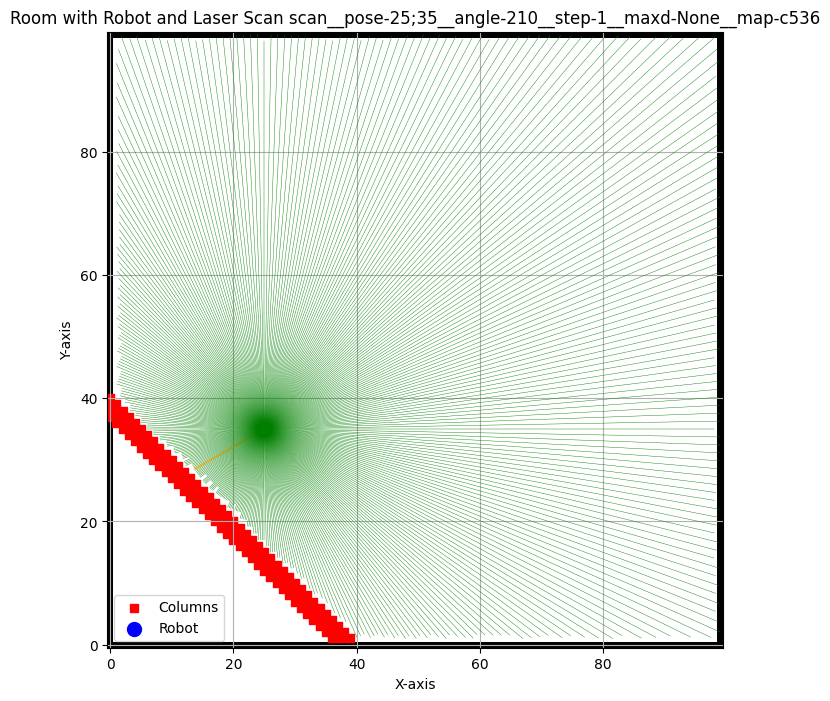

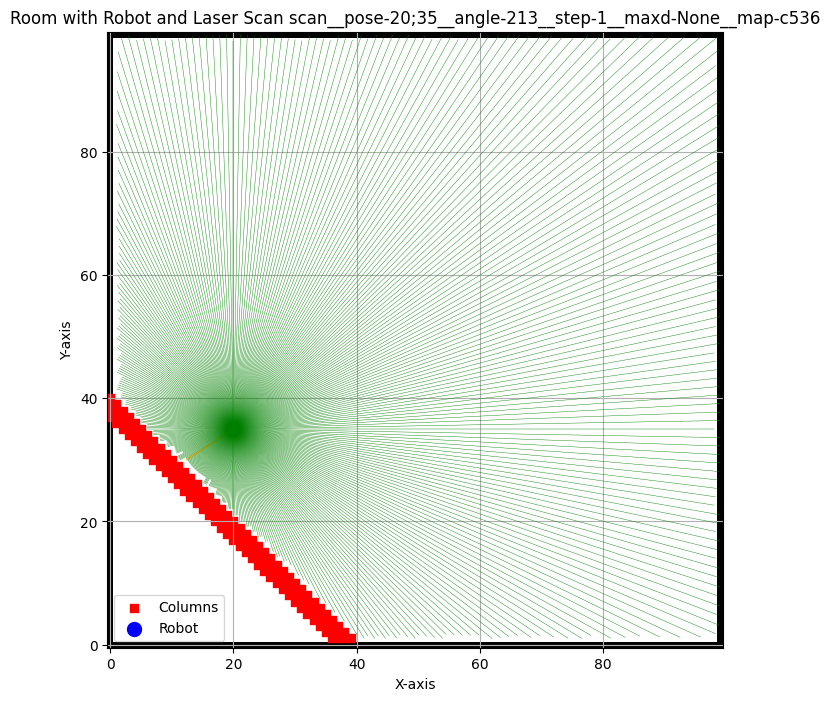

src (1, 360, 2)
Tr[0:2] (2, 3)


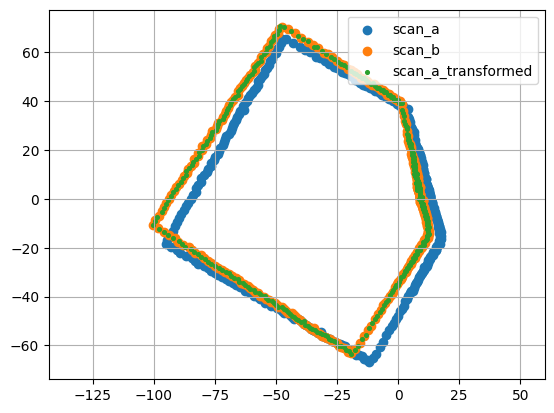

Оценка окончательной матрицы трансформации:
[[ 0.99868133  0.05133806 -4.16501056]
 [-0.05133806  0.99868133  2.73952161]
 [ 0.          0.          1.        ]]
Начальная позиция (scan1):
(25, 35)
Ожидаемая трансформированная позиция (scan2):
(20, 35)
Трансформация (dx, dy):
[-4.165010556815118, 2.7395216081697145]
Ожидаемая трансформация (dx, dy):
[-5  0]
Трансформация (angle, r):
(146.66521602314924, 4.9852072755312955)
Трансформированная начальная позиция (scan_a_pose_t):
[20.83498944318488, 37.73952160816972]
Разница:
[-0.83498944 -2.73952161]
Разница (r):
2.863945881447307
% Ошибки как площадь круга / на площадь карты:
0.26
Погрешность в % (размер карты 100):
2.86
Удаленность реальных позиций:
4.985207275531297
Угол поворота:
2.9427477707099268
Ожидаемый угол поворота:
3
Разница угла поворота:
-0.05725222929007323
Разница угла поворота, %:
-1.91
% ошибки от 360 градусов:
-0.02


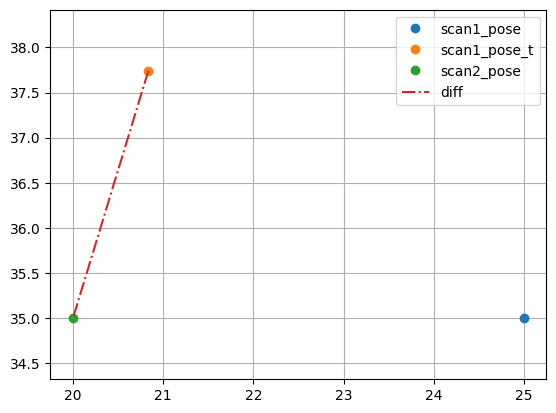

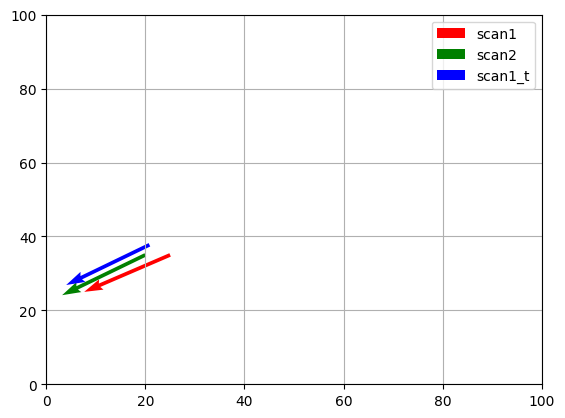

In [44]:
# Задаем размеры комнаты: квадрат 100 на 100
MAP_SIZE = 100
ROOM_SIZE = (MAP_SIZE, MAP_SIZE)
ROOM = np.zeros(ROOM_SIZE)

# Создаем скошенную стену
COLUMN_POSITIONS = [
    *[(i, 40 - i) for i in range(0, 40)],
    *[(i, 39 - i) for i in range(0, 39)],
    *[(i, 38 - i) for i in range(0, 38)],
    *[(i, 37 - i) for i in range(0, 37)],
]

# Заполняем занятые части карты единичками
for col in COLUMN_POSITIONS:
    ROOM[col[::-1]] = 1

# Стены тоже единички
for i in range(MAP_SIZE):
    ROOM[(0, i)] = 1
    ROOM[(i, 0)] = 1
    ROOM[(i, MAP_SIZE - 1)] = 1
    ROOM[(MAP_SIZE - 1, i)] = 1


##### ##### ##### ##### ##### ##### ##### ##### ##### #####
##### #####         СТАРТУЕМ ЭКСПЕРИМЕНТ        ##### #####
##### ##### ##### ##### ##### ##### ##### ##### ##### #####

ROBOT_POSITION_A = (25, 35)
ANGLE0_A = 210

ROBOT_POSITION_B = (20, 35)
ANGLE0_B = 213

# Шаг угла сканирования (в градусах)
ANGLE_STEP = 1

# Максимальная дистанция при имитации лидара
MAX_DISTANCE = None

# Длина вектора для визуального восприятия
DRAW_VECTOR_LENGTH = 20

run_scan_matching(
    ROBOT_POSITION_A,
    ANGLE0_A,
    ROBOT_POSITION_B,
    ANGLE0_B,
    map_size=MAP_SIZE,
    room=ROOM,
    column_positions=COLUMN_POSITIONS,
    angle_step=ANGLE_STEP,
    max_distance=MAX_DISTANCE,
    draw_vector_length=DRAW_VECTOR_LENGTH,
)
